In [1]:
# Robustly add project root to sys.path for src imports (works in Jupyter)
import sys, os
cwd = os.getcwd()
if os.path.isdir(os.path.join(cwd, 'src')):
    project_root = cwd
elif os.path.isdir(os.path.join(os.path.dirname(cwd), 'src')):
    project_root = os.path.dirname(cwd)
else:
    raise RuntimeError('Could not find src directory in current or parent directory.')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Leak Localization with GNNs: End-to-End Pipeline

This notebook demonstrates the full workflow for leak localization in water distribution networks using Graph Neural Networks (GNNs). It leverages the modular codebase in the `src/` directory for data processing, model training, evaluation, and experiment management.

## Table of Contents
1. [Project Overview](#overview)
2. [Environment Setup](#setup)
3. [Data Inspection](#data)
4. [Data Processing (Optional)](#processing)
5. [Train/Validation/Test Split](#split)
6. [Model Training](#training)
7. [Evaluation & Metrics](#evaluation)
8. [Experiment Management](#experiments)
9. [Top Experiments](#top)

---

## 1. Project Overview <a id='overview'></a>

This project aims to localize leaks in water distribution networks using GNNs. The pipeline includes:
- Synthetic scenario generation (hydraulic simulation)
- Data processing and feature engineering
- GNN model definition and training
- Evaluation and experiment tracking

All core logic is implemented in the `src/` directory for reproducibility and modularity.

## 2. Environment Setup <a id='setup'></a>

Install required packages (if not already installed):

In [2]:
# !pip install torch torch-geometric h5py wntr scikit-learn pandas tqdm tensorboard

In [3]:
import numpy as np

import pandas as pd

## 3. Data Inspection <a id='data'></a>

Let's inspect the processed dataset and visualize a sample.

In [4]:
# Load the dataset and inspect a sample
from src.datasets import WDNLeakDataset
from src.config import PROJECT_ROOT # Import project root
# Assuming default paths (root='.', processed_dir='data/processed')
# Adjust if your paths differ
dataset = WDNLeakDataset(root=PROJECT_ROOT, processed_dir='data/processed') # Use PROJECT_ROOT

if len(dataset) > 0:
    sample = dataset[0]
    print(f"Dataset size: {len(dataset)}")
    print(f"Sample 0:\n{sample}")
    print(f"  Node features (x) shape: {sample.x.shape}")
    print(f"  Edge index shape: {sample.edge_index.shape}")
    print(f"  Edge attributes (edge_attr) shape: {sample.edge_attr.shape}")
    print(f"  Labels (y) shape: {sample.y.shape}")

    # Verify alignment: edge_index columns vs edge_attr rows
    if sample.edge_index.shape[1] == sample.edge_attr.shape[0]:
        print("[OK] edge_index and edge_attr dimensions match.")
    else:
        print("[!!WARNING!!] edge_index and edge_attr dimensions MISMATCH!")

    # Verify alignment: edge_index columns vs y rows (if y is per-edge)
    # Note: This assumes y represents edge labels. Adjust if y represents node or graph labels.
    if sample.y.ndim == 1 and sample.edge_index.shape[1] == sample.y.shape[0]:
        print("[OK] edge_index and y dimensions match (assuming y is per-edge label).")
    elif sample.y.ndim > 1 or sample.edge_index.shape[1] != sample.y.shape[0]:
        print(f"[INFO] edge_index ({sample.edge_index.shape[1]}) and y ({sample.y.shape}) dimensions do not match (y might not be per-edge label).")
else:
    print("Dataset is empty or could not be loaded.")
    sample = None # Set sample to None if dataset is empty

C:\Users\JOSAPHAT\AppData\Roaming\Python\Python312\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Dataset size: 1200
Sample 0:
Data(x=[97, 26], edge_index=[2, 238], edge_attr=[238, 4], y=[238], num_nodes=97)
  Node features (x) shape: torch.Size([97, 26])
  Edge index shape: torch.Size([2, 238])
  Edge attributes (edge_attr) shape: torch.Size([238, 4])
  Labels (y) shape: torch.Size([238])
[OK] edge_index and edge_attr dimensions match.
[OK] edge_index and y dimensions match (assuming y is per-edge label).


Processing...
Done!


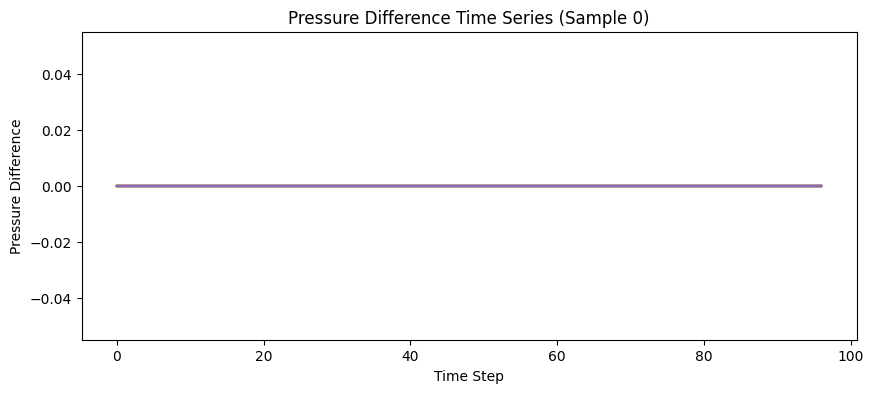

In [5]:
# Visualize node features (pressure diff + elevation)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(sample.x[:, :-1])  # All time steps (excluding elevation)
plt.title('Pressure Difference Time Series (Sample 0)')
plt.xlabel('Time Step')
plt.ylabel('Pressure Difference')
plt.show()

## 4. Data Processing (Optional) <a id='processing'></a>

If you need to process raw HDF5 scenarios into PyTorch Geometric format, run the following cell. (This is usually done once; skip if already processed.)

In [6]:
# from src import process_data
# process_data.main()  # Uncomment to process raw data

## 5. Train/Validation/Test Split <a id='split'></a>

Splitting is handled by `src/split_data.py`. If splits already exist, skip this step.

In [7]:
from src import split_data

# Split data into train, validation, and test sets and save indices\n
train_idx, val_idx, test_idx = split_data.split_train_val_test_and_save(dataset, test_size=0.2, val_fraction=0.15)

Initial split: 960 train, 240 test samples
Second split: 816 final train, 144 validation samples
--------------------
Saved final train indices: 816 samples to d:\Projets\New_soneb_work\experiments\splits\train_idx.npy
Saved validation indices: 144 samples to d:\Projets\New_soneb_work\experiments\splits\val_idx.npy
Saved test indices: 240 samples to d:\Projets\New_soneb_work\experiments\splits\test_idx.npy
--------------------


## 6. Model Training <a id='training'></a>

Train the GNN model using the provided pipeline. This will log metrics and save the best model checkpoint.

In [8]:
from src import train

#This will run the full training pipeline (train/val split, early stopping, logging)
train.train_pipeline()  # Uncomment to train (can take time depending on data size)

[Experiment Management] Assigned experiment_id: 6
[Experiment Management] Created experiment directory: d:\Projets\New_soneb_work\experiments\6
Config snapshot saved to d:\Projets\New_soneb_work\experiments\6\config_snapshot.py
Full dataset size: 1200
Loaded 816 train indices.
Loaded 144 validation indices.
Max validation index: 1197
Train subset size: 816
Validation subset size: 144
Starting training...


Processing...
Done!
C:\Users\JOSAPHAT\AppData\Roaming\Python\Python312\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss=0.6084 | Val Loss=0.0176 | Val AUC-PR=0.0067
[INFO] Saved validation predictions to d:\Projets\New_soneb_work\experiments\6\val_pred_scores.npz
Epoch 2: Train Loss=0.0113 | Val Loss=0.0050 | Val AUC-PR=0.0123
[INFO] Saved validation predictions to d:\Projets\New_soneb_work\experiments\6\val_pred_scores.npz
Epoch 3: Train Loss=0.0058 | Val Loss=0.0042 | Val AUC-PR=0.0073
[INFO] Saved validation predictions to d:\Projets\New_soneb_work\experiments\6\val_pred_scores.npz
Epoch 4: Train Loss=0.0053 | Val Loss=0.0042 | Val AUC-PR=0.0116
[INFO] Saved validation predictions to d:\Projets\New_soneb_work\experiments\6\val_pred_scores.npz
Epoch 5: Train Loss=0.0052 | Val Loss=0.0042 | Val AUC-PR=0.0117
[INFO] Saved validation predictions to d:\Projets\New_soneb_work\experiments\6\val_pred_scores.npz
Epoch 6: Train Loss=0.0050 | Val Loss=0.0040 | Val AUC-PR=0.0116
[INFO] Saved validation predictions to d:\Projets\New_soneb_work\experiments\6\val_pred_scores.npz
Epoch 7: Train L

Using latest experiment ID: 6
Loading validation scores from: d:\Projets\New_soneb_work\experiments\6\val_pred_scores.npz
Loaded 34272 validation labels and scores.
Number of positive labels in validation set: 234

Optimal threshold based on validation F1 score: 0.0854
Best F1 score on validation set: 0.0180


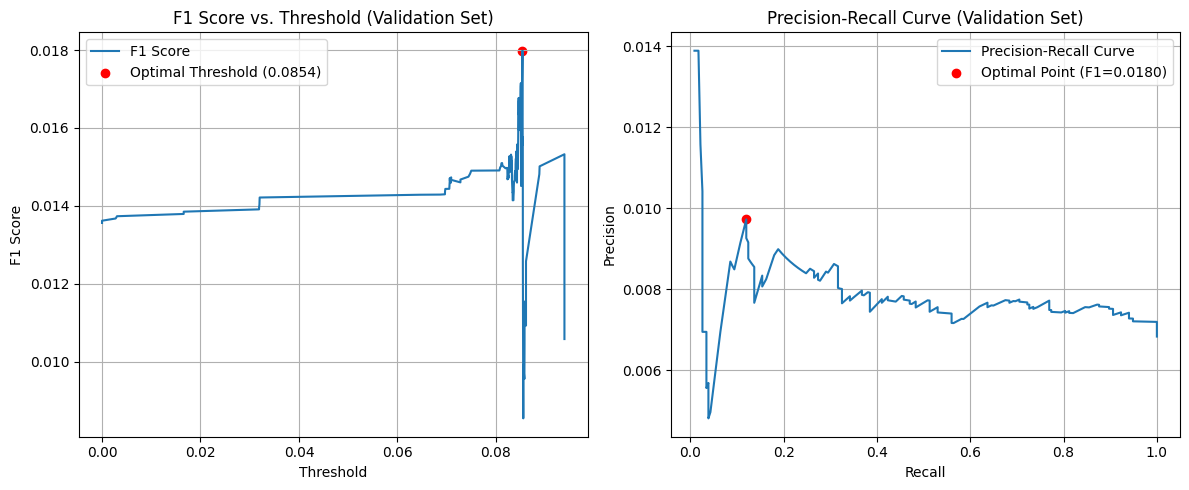

Optimal threshold saved to: d:\Projets\New_soneb_work\experiments\6\optimal_threshold.txt


In [9]:


# Cell to find optimal threshold based on validation set F1 score

import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score
from pathlib import Path
import matplotlib.pyplot as plt
import os # Import os for path joining

# --- Configuration ---
# Define base directory relative to the notebook location
BASE_DIR = Path(os.getcwd()).parent # Assumes notebook is in 'notebooks' subdir

# Load latest experiment_id
experiment_id_file = BASE_DIR / "experiments" / "experiment_id.txt"
try:
    with open(experiment_id_file) as f:
        experiment_id = int(f.read().strip())
    print(f"Using latest experiment ID: {experiment_id}")
except FileNotFoundError:
    print(f"Error: {experiment_id_file} not found. Please set experiment_id manually.")
    experiment_id = None # Or set a default if needed

# --- Load Validation Data ---
if experiment_id is not None:
    # Correct path according to the new structure in src/paths.py and src/train.py
    # The file is now named 'val_pred_scores.npz' inside the experiment directory
    expected_path = BASE_DIR / "experiments" / str(experiment_id) / "val_pred_scores.npz"
    val_pred_path = None
    if expected_path.exists():
        val_pred_path = expected_path
        print(f"Loading validation scores from: {val_pred_path}")
    else:
         # Check the old location just in case, for backward compatibility during transition
        old_path_1 = BASE_DIR / "experiments" / "runs" / f"val_pred_scores_{experiment_id}.npz" # Old log dir location
        old_path_2 = BASE_DIR / "experiments" / f"val_pred_scores_{experiment_id}.npz" # Even older location?
        if old_path_1.exists():
             val_pred_path = old_path_1
             print(f"Loading validation scores from OLD location: {val_pred_path}")
        elif old_path_2.exists():
             val_pred_path = old_path_2
             print(f"Loading validation scores from VERY OLD location: {val_pred_path}")
        else:
            raise FileNotFoundError(f"Validation prediction file not found for experiment {experiment_id} in expected location: {expected_path} (or older locations)")

    data = np.load(val_pred_path)
    y_true_val = data["y_true"]
    y_score_val = data["y_score"] # These are already sigmoid probabilities
    print(f"Loaded {len(y_true_val)} validation labels and scores.")
    print(f"Number of positive labels in validation set: {int(y_true_val.sum())}")
else:
    raise ValueError("Cannot proceed without a valid experiment_id.")

# --- Find Optimal Threshold based on F1 ---
if int(y_true_val.sum()) > 0: # Ensure there are positive samples to calculate PR curve
    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_true_val, y_score_val)

    # Calculate F1 score for each threshold (handle division by zero)
    # Note: thresholds array is one element shorter than precision/recall
    f1_scores = np.zeros_like(thresholds)
    # Use precision/recall values corresponding to this threshold
    # Need to use i for precision/recall because they have one more element
    # Avoid division by zero
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9) # Add epsilon for stability


    # Find the threshold that maximizes F1 score
    best_f1_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[best_f1_idx]
    best_f1_score = f1_scores[best_f1_idx]

    print(f"\nOptimal threshold based on validation F1 score: {optimal_threshold:.4f}")
    print(f"Best F1 score on validation set: {best_f1_score:.4f}")

    # --- Plot Precision-Recall Curve and F1 vs Threshold ---
    plt.figure(figsize=(12, 5))

    # Plot F1 vs Threshold
    plt.subplot(1, 2, 1)
    plt.plot(thresholds, f1_scores, label='F1 Score')
    plt.scatter(optimal_threshold, best_f1_score, marker='o', color='red', label=f'Optimal Threshold ({optimal_threshold:.4f})')
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title("F1 Score vs. Threshold (Validation Set)")
    plt.grid(True)
    plt.legend()

    # Plot Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall[:-1], precision[:-1], label='Precision-Recall Curve') # Exclude last point as per sklearn docs
    plt.scatter(recall[best_f1_idx], precision[best_f1_idx], marker='o', color='red', label=f'Optimal Point (F1={best_f1_score:.4f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (Validation Set)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # --- Save the optimal threshold ---
    # Save inside the specific experiment directory
    exp_dir = BASE_DIR / "experiments" / str(experiment_id)
    threshold_save_path = exp_dir / "optimal_threshold.txt" # Consistent filename
    try:
        # Ensure the experiment directory exists (it should, but double-check)
        os.makedirs(exp_dir, exist_ok=True)
        with open(threshold_save_path, 'w') as f:
            f.write(str(optimal_threshold))
        print(f"Optimal threshold saved to: {threshold_save_path}")
    except Exception as e:
        print(f"Error saving optimal threshold: {e}")

else:
    print("\nNo positive samples found in the validation set. Cannot determine optimal threshold or plot curves.")
    optimal_threshold = 0.5 # Default to 0.5 if no positives
    print("Defaulting threshold to 0.5 for evaluation script.")
     # --- Save the default threshold ---
    # Save inside the specific experiment directory
    exp_dir = BASE_DIR / "experiments" / str(experiment_id)
    threshold_save_path = exp_dir / "optimal_threshold.txt" # Consistent filename
    try:
        # Ensure the experiment directory exists (it should, but double-check)
        os.makedirs(exp_dir, exist_ok=True)
        with open(threshold_save_path, 'w') as f:
            f.write(str(optimal_threshold))
        print(f"Default threshold (0.5) saved to: {threshold_save_path}")
    except Exception as e:
        print(f"Error saving default threshold: {e}")




## 7. Evaluation & Metrics <a id='evaluation'></a>

Evaluate the trained model on the test set and display key metrics.

In [10]:
from src.experiment_utils import get_last_experiment_id
from src import evaluate

# Evaluate and save predictions for the default fold (or specify fold number)
    # Get the ID of the experiment that was just run (presumably)
experiment_id = get_last_experiment_id()
print(f"[Evaluation] Using experiment_id: {experiment_id}")

evaluate.evaluate_and_save_predictions(experiment_id_to_eval=experiment_id) # Use the optimal threshold

[Evaluation] Using experiment_id: 6
[Evaluation] Using specified experiment_id: 6
[Evaluation] Loaded optimal threshold: 0.0854 from d:\Projets\New_soneb_work\experiments\6\optimal_threshold.txt


Processing...
Done!


Test set evaluation (using threshold=0.0854):
AUC-PR: 0.0098
F1 (Thresholded): 0.0145
Recall (Thresholded): 0.8543
Precision (Thresholded): 0.0073
MRR: 0.0128
[Experiment Management] Results appended to registry and ranking updated for experiment_id: 6
Hits@1: 0.0000
Hits@3: 0.0000
Hits@5: 0.0000
FPR: 0.8149
Saved detailed predictions to d:\Projets\New_soneb_work\experiments\6\6_test_predictions.csv


Loaded test predictions from: d:\Projets\New_soneb_work\experiments\6\6_test_predictions.csv
Using optimal threshold: 0.0854


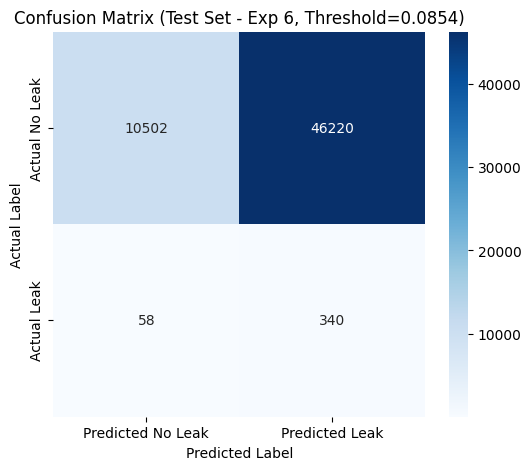

In [11]:
# --- Confusion Matrix for Test Set ---
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
from src import paths # Import paths module

# Get experiment ID (assuming it's already defined from previous cell or loaded again)
if 'experiment_id' not in locals() or experiment_id is None:
    experiment_id_file = BASE_DIR / "experiments" / "experiment_id.txt"
    try:
        with open(experiment_id_file) as f:
            experiment_id = int(f.read().strip())
        print(f"[Confusion Matrix] Using latest experiment ID: {experiment_id}")
    except FileNotFoundError:
         raise FileNotFoundError(f"[Confusion Matrix] Experiment ID file not found at {experiment_id_file}. Cannot proceed.")
    except ValueError:
         raise ValueError(f"[Confusion Matrix] Could not read experiment ID from {experiment_id_file}. Cannot proceed.")

# Define paths using src.paths for consistency
exp_dir = BASE_DIR / "experiments" / str(experiment_id)
predictions_file = paths.predictions_path(experiment_id=experiment_id) # Use function from paths.py
threshold_file = paths.optimal_threshold_path(experiment_id=experiment_id) # Use function from paths.py

# Load predictions
if not os.path.exists(predictions_file):
    raise FileNotFoundError(f"Test predictions file not found: {predictions_file}")
df_preds = pd.read_csv(predictions_file)
print(f"Loaded test predictions from: {predictions_file}")

# Load optimal threshold
optimal_threshold = 0.5 # Default
if not os.path.exists(threshold_file):
    print(f"[Warning] Optimal threshold file not found: {threshold_file}. Using default 0.5 for confusion matrix.")
else:
    try:
        with open(threshold_file, 'r') as f:
            optimal_threshold = float(f.read().strip())
        print(f"Using optimal threshold: {optimal_threshold:.4f}")
    except Exception as e:
        print(f"[Warning] Error reading threshold file {threshold_file}: {e}. Using default 0.5.")

# Calculate binary predictions
y_true_test = df_preds['y_true'].values
y_score_test = df_preds['y_score_prob'].values
y_pred_test = (y_score_test > optimal_threshold).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No Leak', 'Predicted Leak'], 
            yticklabels=['Actual No Leak', 'Actual Leak'])
plt.title(f'Confusion Matrix (Test Set - Exp {experiment_id}, Threshold={optimal_threshold:.4f})')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

## 8. Experiment Management <a id='experiments'></a>

Experiments are tracked in a registry and ranked by metrics. You can inspect the registry as follows:

In [12]:
from src.paths import REGISTRY_PATH

if os.path.exists(REGISTRY_PATH):
    df = pd.read_csv(REGISTRY_PATH)
    display(df.tail())
else:
    print("Experiment registry not found.")

,experiment_id,date,model_type,data_dir,node_in_dim,edge_in_dim,hidden_dim,num_layers,gnn_type,mlp_hidden_dim,...,notes,AUC-PR,F1,recall,precision,mrr,hits@1,hits@3,hits@5,optimal_threshold
2,3,2025-04-16 12:20:04,WDNLeakGNN,d:\Projets\New_soneb_work\data,26,4,128,3,gine,128,...,"Thresholded metrics (F1, Recall, Precision) ca...",0.009598,0.013972,0.798995,0.007048,0.008130,0,0,0,0.280497
3,2,2025-04-16 12:31:21,WDNLeakGNN,D:\Projets\New_soneb_work\data,26,4,128,3,gine,128,...,"Thresholded metrics (F1, Recall, Precision) ca...",0.009598,0.013972,0.798995,0.007048,0.008130,0,0,0,0.280497
4,4,2025-04-16 12:50:28,WDNLeakGNN,d:\Projets\New_soneb_work\data,26,4,128,3,gine,128,...,"Thresholded metrics (F1, Recall, Precision) ca...",0.009355,0.009112,0.010050,0.008333,0.026316,0,0,0,0.207058
5,5,2025-04-16 13:01:32,WDNLeakGNN,d:\Projets\New_soneb_work\data,26,4,128,3,gine,128,...,"Thresholded metrics (F1, Recall, Precision) ca...",0.008927,0.009112,0.010050,0.008333,0.013333,0,0,0,0.141819
6,6,2025-04-16 13:19:54,WDNLeakGNN,d:\Projets\New_soneb_work\data,26,4,128,3,gine,128,...,"Thresholded metrics (F1, Recall, Precision) ca...",0.009843,0.014481,0.854271,0.007302,0.012821,0,0,0,0.085406


## 9. Top Experiments <a id='top'></a>

Show the top experiments by AUC-PR, F1, and recall.

In [13]:
from src import show_top_experiments

show_top_experiments.show_top_experiments(n=5)

Top 5 Experiments:
experiment_id	date	model_type	data_dir	node_in_dim	edge_in_dim	hidden_dim	num_layers	gnn_type	mlp_hidden_dim	dropout	norm_type	hyperparameters	notes	AUC-PR	F1	recall	precision	mrr	hits@1	hits@3	hits@5	optimal_threshold
6	2025-04-16 13:19:54	WDNLeakGNN	d:\Projets\New_soneb_work\data	26	4	128	3	gine	128	0.3	layer	{"lr": null, "batch_size": 32, "gamma": null, "weight_decay": null}	Thresholded metrics (F1, Recall, Precision) calculated using optimal threshold 0.0854 from validation set.	0.009843080260318517	0.014481025597342306	0.8542713567839196	0.007302405498281787	0.01282051282051282	0	0	0	0.08540646
3	2025-04-16 12:20:04	WDNLeakGNN	d:\Projets\New_soneb_work\data	26	4	128	3	gine	128	0.3	layer	{"lr": null, "batch_size": 32, "gamma": null, "weight_decay": null}	Thresholded metrics (F1, Recall, Precision) calculated using optimal threshold 0.2805 from validation set.	0.009598034462690787	0.013972494397820643	0.7989949748743719	0.007047872340425532	0.008130081300813009	0	

---
## Notes
- For advanced usage (cross-validation, ablation studies, etc.), extend the code in `src/` and add new notebook sections as needed.
- For troubleshooting, consult the `README.md` and code comments in each module.

This notebook is the main entry point for running and analyzing the leak localization pipeline.